In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 형태소 분석: KoNLPy 사용

### 형태소 분석기 종류
*  Hannanum - KAIST 말뭉치를 이용해 생성된 사전
*  Kkma - 세종 말뭉치를 이용해 생성된 사전 (꼬꼬마)
*  Komoran- Java로 쓰여진 오픈소스 한글 형태소 분석기
*  Twitter(Okt) - 오픈소스 한글 형태소 분석기
*  Mecab - 세종 말뭉치로 만들어진 CSV형태의 사전
*  bareun - 한국언론진흥재단이 딥러닝 방식으로 만든 형태소 분석기

### 품사 태깅(tag): 형태소별로 구분하고 마크업

### 명사 추출: 문장의 주성분 요소인 명사만 추출. 워드클라우드 전단계 작업.

형태소 분석기 비교: https://konlpy.org/ko/v0.5.2/morph/

한국어 품사 태그 비교: https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0

In [ ]:
! pip install konlpy           # konlpy 라이브러리 설치하기.
                               # konlpy는 한국어 분석용이므로 google colab에 설치돼 있지 않음.
                               # 그러나 konlpy 사용을 위해 해야 하는 java 설치와 경로 지정 등은 colab에서 하지 않아도 됨.
from konlpy.tag import *       # konlpy.tag 모듈에 있는 모든 함수 불러오기. 이 가운데 Hannanum도 있음.

okt= Okt()               # Okt() 기능을 하는 객체 okt 할당
# kkma = Kkma()                # Kkma 등 다른 형태소 분석기 사용 가능

In [ ]:
okt.pos("철수는 파이썬을 열심히 학습합니다", norm=True, stem=True)      #형태소 태깅, norm: 문법 어긋난 부분 교정, stem: 원형 복구
okt.morphs("철수는 파이썬을 열심히 학습합니다", norm=True, stem=True)   #형태소 분류
okt.nouns("철수는 파이썬을 열심히 학습합니다")    #명사 추출

# 형태소 분석: kiwipiepy 사용
### https://github.com/bab2min/kiwipiepy
(bab2min(Minchul Lee) 개발)

### kiwi 품사 분류표
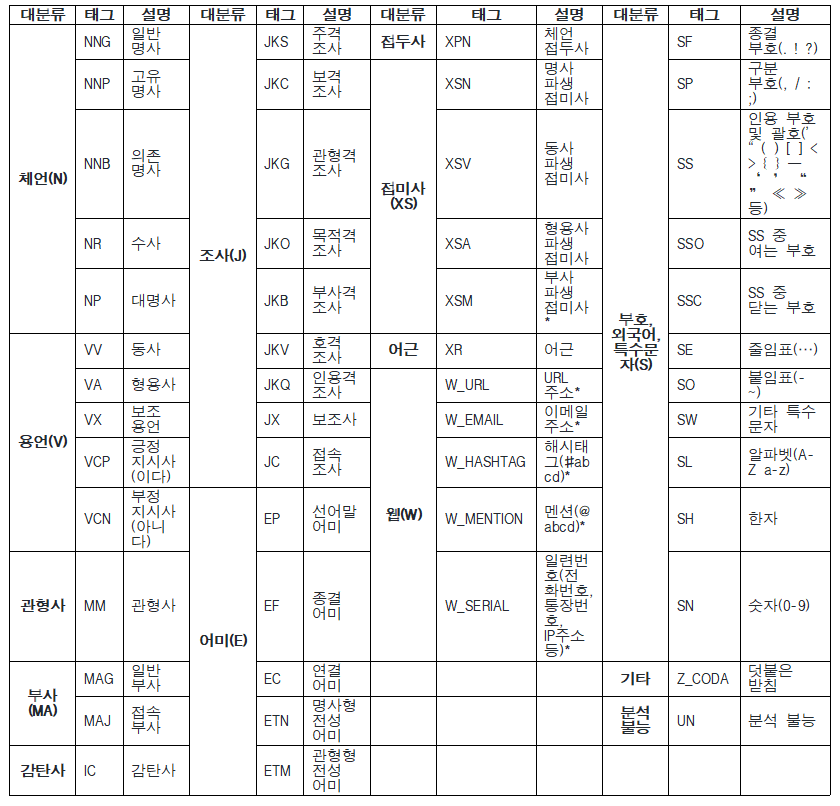

### 패키지 불러오기와 인스턴스 생성

In [ ]:
! pip install kiwipiepy

from kiwipiepy import Kiwi
kiwi = Kiwi()

### 문장 분리와 교정

In [ ]:

txts='''고속도로를 달리던 활어운반차와 SUV가 추돌해 도로에 생선이 쏟아지는 사고가 났습니다.
오늘(4일) 오후 3시 39분쯤 동해고속도로 삼척 방면 북강릉나들목 직전 300m 부근에서 2차선 도로를 달리던 1.3t 활어운반차를 뒤따르던 카니발 차량이 들이받았습니다.'''
kiwi.split_into_sents(txts)

# 문장 분리: 함수화
def sent_split(txts):
    sents=kiwi.split_into_sents(txts)
    sents=[s[0] for s in sents]
    for i,s in enumerate(sents):
        for t in ['"고','"라고','"며', '"라며', '"면서','"라면서']:  #연결조사로 이어진 부분이 분리됨. 이를 연결시키는 장치.
            if s.startswith(t):
                sents[i-1]=sents[i-1]+s
                del sents[i]
            else:
                pass
    return sents

text1='철수는 어려운 파이썬을 열심히 학습합니다 영희도 파이썬을 좋아할까요?'
sent_split(text1)

# 띄어쓰기 안 된 문장 수정
text2='철수는 파이썬을열심히학습합니다'
sents_space=kiwi.space(text2, reset_whitespace=False)
print(sents_space)

# 문법에 어긋난 받침 교정: 전체 교정은 별도의 프로그램 사용해야 함
text3='영희도 파이썬을 좋아할까욬?'
morphs_typos=kiwi.tokenize(text3, normalize_coda=True)
print(morphs_typos)

### 품사 태깅과 추출, 함수화

In [ ]:
text4='철수는 어려운 파이썬 코드를 석달간 열심히 학습해 많은 네이버 뉴스 글을 수집할 수 있었다'
morphs=kiwi.tokenize(text4)
morphs_all=[m[0] for m in morphs]                                            # 모든 품사에 해당하는 형태소 모두 추출
morphs_select=['NNG', 'NNP', 'NP', 'NR', 'VV', 'VX', 'VCP', 'VCN', 'VA','VA-I', 'MM', 'MAG']    # 일반명사, 고유명사, 용언(동사, 형용사 등), 관형사, 일반부사 # 품사 분류표 참조
morphs_main=[m for m in morphs if m[1] in morphs_select]                         # 위 주요 품사 항목 선택
morphs_main=[m[0]+'다' if m[1].startswith('V') else m[0] for m in morphs_main]  # 위 주요 품사에 해당하는 형태소 추출 # stemming(동사-형용사 등 용언은 원형 복구) 적용
morphs_nouns=[m[0] for m in morphs if m[1] in morphs_select[:4]]                # 명사에 해당하는 형태소만 추출
print(morphs_all)
print(morphs_main)
print(morphs_nouns)

In [ ]:
# 함수화: 명사 추출과 주요 품사 추출 수행

! pip install kiwipiepy

import re
from kiwipiepy import Kiwi
kiwi = Kiwi()

def kiwi_tokenize(txt, nouns=True, remove1=False, stopwords=[]):
    '''문자열 txt를 받아 kiwi로 형태소 추출: nouns=명사만 추출 여부, remove1=1음절 토큰 제외 여부, stopwords=불용어 리스트 '''
    try:
        # 정제(cleaning): 비문자숫자 등 노이즈 제거
        txt1=re.sub(r"[^\s가-힣a-zA-Z0-9]", " ", txt)   # re.sub: 문자열 부분 교체. r은 정규표현식 사용한다는 표시.
                                                        # "[^ 가-힣a-zA-Z1-9]"는 한글 영어 숫자 이외의 문자열 의미.
                                                        # txt1=txt1.replace("X", " "):  특정 단어만 삭제할 때에는 replace 함수로 간단히 실행
        # 토큰화(tokenization): 형태소 추출
        morphs=kiwi.tokenize(txt1)
        morphs_all=[m[0] for m in morphs]                # 모든 품사에 해당하는 형태소 모두 추출
        morphs_select=['NNG', 'NNP', 'NP', 'NR', 'VV', 'VX', 'VCP', 'VCN', 'VA','VA-I', 'MM', 'MAG']  # 일반명사, 고유명사, 용언(동사, 형용사 등), 관형사, 일반부사 # 품사 분류표 참조
        # 명사 추출(nou extraction) 여부 선택
        if nouns==True:
            token_lst=[m[0] for m in morphs if m[1] in morphs_select[:4]]
        else:
            token_lst=[m for m in morphs if m[1] in morphs_select]
            # stemming(어간 추출, 동사-형용사 등 용언의 원형 복구) 적용
            token_lst=[m[0]+'다' if m[1].startswith('V') else m[0] for m in token_lst]
        # 1음절 토큰 제외 여부 선택
        if remove1==True:
            token_lst=[t for t in token_lst if len(t)>1 ]
        else:
            pass
        # 불용어(stopwords) 적용: 제외해야 할 토큰들의 집합
        token_lst=[t for t in token_lst if t not in stopwords]
    except:
        token_lst=[]
    return ','.join(token_lst)

In [ ]:
# 함수 연습

txt='''앵커: 오늘은 전국이 대체로 맑고 건조한 가운데 초여름 날씨가 이어지겠습니다.
리포트: 낮 최고 기온은 서울 26도, 대전 20도, 대구 23도로 전국 대부분 지역에서 20도 이상을 나타내겠고, 낮과 밤의 기온 차가 중부 지역은 20도 이상, 남부 내륙은 15도 이상 벌어지겠습니다.
미세먼지는 서울과 경기, 충남, 전북에서 오전에 일시적으로 나쁨 수준을 보이겠고, 인천은 '나쁨'수준을 나타내겠습니다.'''

stopwords=['앵커', '리포트']
token_result=kiwi_tokenize(txt, nouns=False, remove1=False, stopwords=stopwords)
print(token_result)

### 빈도분석, 정규화(normalization), bigram 처리

In [ ]:
from collections import Counter
import nltk
import pprint

# 형태소 분석 후 토큰(token) 빈도 탐색
text5='김철수 과장은 어려운 파이썬 웹데이터 수집 코드를 석달간 열심히 학습했고, 그 결과로 김 과장은 많은 네이버 뉴스와 네이버 댓글을 수집할 수 있었다'
tokens=kiwi_tokenize(text5)    # 명사만 추출
print(tokens)
keywords=Counter(tokens.split(',')).most_common(100)      # 빈도 기준 몇위까지 출력
print(keywords)
bigrams=Counter((list(nltk.bigrams(tokens.split(','))))).most_common(100)
print(bigrams)

# 정규화(normalization): 표현 방법이 다른 단어들을 통합시켜 같은 단어로 만들기
tokens_norm=tokens.replace('김,과장', '김철수,과장')
print(tokens_norm)

# bigram 구성: 두 개 토큰을 묶어 하나의 토큰으로 만들기
tokens_bigram=tokens.replace('네이버,뉴스', '네이버뉴스').replace('네이버,댓글', '네이버댓글')
print(tokens_bigram)

### 사전에 없는 단어 추가

In [ ]:
text5='갑철수는 파이썬을 열심히 학습합니다'
kiwi.add_user_word("갑철수", "NNP")
morphs=kiwi.tokenize(text5)
morphs_all=[m[0] for m in morphs]
print(morphs_all)

## 실습: 데이터 불러오기

In [ ]:
import pandas as pd

df=pd.read_excel('/content/drive/MyDrive/2024_1_class/경희대맛집_블로그.xlsx')
df.info()

### 형태소 분석으로 토큰 추출

In [ ]:
stopwords=['블로그', '링크', '추천']
df['description_nouns']=df['description'].apply(lambda x: kiwi_tokenize(x, nouns=True, remove1=True, stopwords=stopwords))

# 필요하면 df.to_excel('/content/drive/MyDrive/2024_1_class/경희대맛집_블로그_명사추출.xlsx') 사용해 저장

# 워드클라우드(word cloud) 분석: 출현 빈도 상위권 단어 시각화

### 단어 출현 빈도 계산: Counter 함수 활용

In [ ]:
from collections import Counter

tokens_all=','.join(list(df['description_nouns'])).split(',')
keywords_all=Counter(tokens_all).most_common(100)
print(keywords_all)

df_keywords = pd.DataFrame(keywords_all, columns=["단어", "출현빈도"])   # 단어와 출현빈도 표로 만들기
#df_keywords.to_excel('/content/drive/MyDrive/2024_1_class/경희대맛집_블로그_키워드빈도.xlsx')

### 한글 폰트 설치와 패키지 불러오기

In [ ]:
! apt-get update -qq
! apt-get install fonts-nanum* -qq

from wordcloud import WordCloud
import matplotlib.pyplot as plt

### 워드클라우드 그리기

In [ ]:
wordcloud = WordCloud(
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',       # 폰트 저장 경로
    background_color='white',
    colormap = "Accent_r",                                                         # 사용 색상 지정  # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    width=1500, height=1000                                                        # 그림 픽셀
    ).generate_from_frequencies(dict(keywords_all))
plt.figure(figsize=(12,8))                                                         # 그림 크기
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 그림 저장은 그림에 마우스 위치하고 오른쪽 클릭 후 이미지 복사

# (참고) 한국어 교정(correction)
부산대 인공지능연구실(http://speller.cs.pusan.ac.kr/) API 활용

In [ ]:
import requests
import json

def correction(txt):
    '''문자열 txt를 입력하면 교정된 결과를 출력. 부산대 인공지능연구실(http://speller.cs.pusan.ac.kr/) API 활용'''
    response = requests.post('http://164.125.7.61/speller/results', data={'text1': txt})
    data = response.text.split('data = [', 1)[-1].split('];', 1)[0]
    data = json.loads(data)
    error_dct={}
    for error in data['errInfo']:
        try:
            error['candWord']=error['candWord'].split('|')[0]
            error_dct[error['orgStr']]=error['candWord']
        except:
            pass
    for error, correct in error_dct.items():
        txt=txt.replace(error, correct)
        result=txt
    return result


In [ ]:
txt='''철수는 어려훈 파이썬 코드를 석달간열심히 학습해 많은 네이버 뉴스을 수집할 있었다'''
print(correction(txt))